## 토큰화 및 토큰 임베딩

In [2]:
# 띄어쓰기 단위로 분리
input_text = "나는 최근 파리 여행을 다녀왔다"
input_text_list = input_text.split()
print("input_text_list: ", input_text_list)

# 토큰 -> 아이디 딕셔너리와 아이디 -> 토큰 딕셔너리 만들기
str2idx = {word:idx for idx, word in enumerate(input_text_list)}
idx2str = {idx:word for idx, word in enumerate(input_text_list)}
print("str2idx: ", str2idx)
print("idx2str: ", idx2str)

# 토큰을 토큰 아이디로 변환
input_ids = [str2idx[word] for word in input_text_list]
print("input_ids: ", input_ids)

import torch
import torch.nn as nn

embedding_dim = 16
embed_layer = nn.Embedding(len(str2idx), embedding_dim)

input_embeddings = embed_layer(torch.tensor(input_ids)) # (5, 16)
input_embeddings = input_embeddings.unsqueeze(0) # (1, 5, 16) 트랜스포머나 RNN과 같은 모델들은 3차원 입력(배치, 시퀀스 길이, 피처) - 배치 단위로 학습하기 때문에 첫 번째 차원이 배치 크기
input_embeddings.shape


input_text_list:  ['나는', '최근', '파리', '여행을', '다녀왔다']
str2idx:  {'나는': 0, '최근': 1, '파리': 2, '여행을': 3, '다녀왔다': 4}
idx2str:  {0: '나는', 1: '최근', 2: '파리', 3: '여행을', 4: '다녀왔다'}
input_ids:  [0, 1, 2, 3, 4]


torch.Size([1, 5, 16])

### 절대적 위치 인코딩

In [8]:
embedding_dim = 16
max_position = 12
# 토큰 임베딩 층 생성
embed_layer = nn.Embedding(len(str2idx), embedding_dim)
# 위치 인코딩 층 생성
position_embed_layer = nn.Embedding(max_position, embedding_dim)

position_ids = torch.arange(len(input_ids), dtype=torch.long).unsqueeze(0)
position_encodings = position_embed_layer(position_ids)
token_embeddings = embed_layer(torch.tensor(input_ids)) # (5, 16)
token_embeddings = token_embeddings.unsqueeze(0) # (1, 5, 16)
# 토큰 임베딩과 위치 인코딩을 더해 최종 입력 임베딩 생성
input_embeddings = token_embeddings + position_encodings
input_embeddings.shape

torch.Size([1, 5, 16])

### 어텐션 연산 

In [51]:
from math import sqrt
import torch.nn.functional as F

def compute_attention(querys, keys, values, is_causal=False):
    dim_k = querys.size(-1) # 16
    scores = querys @ keys.transpose(-2, -1) / sqrt(dim_k) #  (batch_size, seq_len, seq_len)
    weights = F.softmax(scores, dim=-1)
    
    return weights @ values # (batch_size, seq_len, dim_k)

class AttentionHead(nn.Module):
  def __init__(self, token_embed_dim, head_dim, is_causal=False):
    super().__init__()
    self.is_causal = is_causal
    self.weight_q = nn.Linear(token_embed_dim, head_dim) # 쿼리 벡터 생성을 위한 선형 층 (batch_size, seq_len, dim_k)
    self.weight_k = nn.Linear(token_embed_dim, head_dim) # 키 벡터 생성을 위한 선형 층 (batch_size, seq_len, dim_k)
    self.weight_v = nn.Linear(token_embed_dim, head_dim) # 값 벡터 생성을 위한 선형 층 (batch_size, seq_len, dim_v)

  def forward(self, querys, keys, values):
    outputs = compute_attention(
        self.weight_q(querys),  # 쿼리 벡터
        self.weight_k(keys),    # 키 벡터
        self.weight_v(values),  # 값 벡터
        is_causal=self.is_causal
    )
    return outputs

attention_head = AttentionHead(embedding_dim, embedding_dim)
after_attention_embeddings = attention_head(input_embeddings, input_embeddings, input_embeddings)
# after_attention_embeddings.shape


### 멀티헤드 어텐션 

In [69]:
class MultiheadAttention(nn.Module):
  def __init__(self, token_embed_dim, d_model, n_head, is_causal=False):
    super().__init__()
    self.n_head = n_head
    self.is_causal = is_causal
    self.weight_q = nn.Linear(token_embed_dim, d_model)
    self.weight_k = nn.Linear(token_embed_dim, d_model)
    self.weight_v = nn.Linear(token_embed_dim, d_model)
    self.concat_linear = nn.Linear(d_model, d_model)

  def forward(self, querys, keys, values, is_causal=False):
    B, T, C = querys.size()
    querys = self.weight_q(querys).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
    keys = self.weight_k(keys).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
    values = self.weight_v(values).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
    attention = compute_attention(querys, keys, values, is_causal)
    output = attention.transpose(1, 2).contiguous().view(B, T, C)
    output = self.concat_linear(output)
    return output

n_head = 4
mh_attention = MultiheadAttention(embedding_dim, embedding_dim, n_head)
after_attention_embeddings = mh_attention(input_embeddings, input_embeddings, input_embeddings)
after_attention_embeddings.shape

torch.Size([1, 5, 16])

### 층 정규화 

In [32]:
norm = nn.LayerNorm(embedding_dim)
norm_x = norm(input_embeddings)
norm_x.shape # torch.Size([1, 5, 16])

norm_x.mean(dim=-1).data, norm_x.std(dim=-1).data

# (tensor([[ 2.2352e-08, -1.1176e-08, -7.4506e-09, -3.9116e-08, -1.8626e-08]]),
#  tensor([[1.0328, 1.0328, 1.0328, 1.0328, 1.0328]]))

(tensor([[-2.9802e-08,  2.2352e-08,  1.4901e-08,  2.6077e-08,  3.7253e-08]]),
 tensor([[1.0328, 1.0328, 1.0328, 1.0328, 1.0328]]))

### 피드포워드 층 

In [35]:
import torch
import torch.nn as nn

class PreLayerNormFeedForward(nn.Module):
  def __init__(self, d_model, dim_feedforward, dropout):
    super().__init__()
    self.linear1 = nn.Linear(d_model, dim_feedforward) # 선형 층 1
    self.linear2 = nn.Linear(dim_feedforward, d_model) # 선형 층 2
    self.dropout1 = nn.Dropout(dropout) # 드랍아웃 층 1
    self.dropout2 = nn.Dropout(dropout) # 드랍아웃 층 2
    self.activation = nn.GELU() # 활성 함수
    self.norm = nn.LayerNorm(d_model) # 층 정규화

  def forward(self, src):
    x = self.norm(src)
    x = x + self.linear2(self.dropout1(self.activation(self.linear1(x))))
    x = self.dropout2(x)
    return x


# 모델 초기화
d_model = 512  # 입력 차원
dim_feedforward = 2048  # 확장할 차원
dropout = 0.1  # 드롭아웃 비율

ffn = PreLayerNormFeedForward(d_model, dim_feedforward, dropout)

# 입력 데이터 생성
batch_size = 32
seq_length = 10
x = torch.randn(batch_size, seq_length, d_model)

# forward 실행(내부적으로 forward 함수 호출)
output = ffn(x) 

# 출력 shape 확인
print(f"Input shape: {x.shape}")  # [32, 10, 512]
print(f"Output shape: {output.shape}")  # [32, 10, 512]

Input shape: torch.Size([32, 10, 512])
Output shape: torch.Size([32, 10, 512])


### 인코더 

### 인코더 층 

In [36]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, d_model, nhead, dim_feedforward, dropout):
    super().__init__()
    self.attn = MultiheadAttention(d_model, d_model, nhead) # 멀티 헤드 어텐션 클래스
    self.norm1 = nn.LayerNorm(d_model) # 층 정규화
    self.dropout1 = nn.Dropout(dropout) # 드랍아웃
    self.feed_forward = PreLayerNormFeedForward(d_model, dim_feedforward, dropout) # 피드포워드

  def forward(self, src):
    norm_x = self.norm1(src)
    attn_output = self.attn(norm_x, norm_x, norm_x)
    x = src + self.dropout1(attn_output) # 잔차 연결

    # 피드 포워드
    x = self.feed_forward(x)
    return x

In [38]:
import copy
def get_clones(module, N):
  return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class TransformerEncoder(nn.Module):
  def __init__(self, encoder_layer, num_layers):
    super().__init__()
    self.layers = get_clones(encoder_layer, num_layers)
    self.num_layers = num_layers
    self.norm = norm

  def forward(self, src):
    output = src
    for mod in self.layers:
        output = mod(output)
    return output

import torch
import torch.nn as nn

# 하이퍼파라미터 설정
d_model = 512          # 모델의 차원
n_head = 8            # 어텐션 헤드 수
dim_feedforward = 2048 # 피드포워드 네트워크의 hidden 차원
dropout = 0.1         # 드롭아웃 비율
num_layers = 6        # 인코더 레이어 수
batch_size = 32       # 배치 크기
seq_length = 100      # 시퀀스 길이

# 인코더 레이어 생성
encoder_layer = TransformerEncoderLayer(
    d_model=d_model,
    nhead=n_head,
    dim_feedforward=dim_feedforward,
    dropout=dropout
)

# 전체 인코더 생성
transformer_encoder = TransformerEncoder(
    encoder_layer=encoder_layer,
    num_layers=num_layers
)

# 입력 데이터 생성 (임의의 데이터)
src = torch.randn(batch_size, seq_length, d_model)

# 모델 실행
output = transformer_encoder(src)

# 출력 shape 확인
print(f"Input shape: {src.shape}")

torch.Size([32, 8, 100, 100])
torch.Size([32, 8, 100, 64])
torch.Size([32, 8, 100, 100])
torch.Size([32, 8, 100, 64])
torch.Size([32, 8, 100, 100])
torch.Size([32, 8, 100, 64])
torch.Size([32, 8, 100, 100])
torch.Size([32, 8, 100, 64])
torch.Size([32, 8, 100, 100])
torch.Size([32, 8, 100, 64])
torch.Size([32, 8, 100, 100])
torch.Size([32, 8, 100, 64])
Input shape: torch.Size([32, 100, 512])


### 디코더 층 

### 어텐션 마스크 

In [46]:
def compute_attention(querys, keys, values, is_causal=False):
	dim_k = querys.size(-1) # 16
	scores = querys @ keys.transpose(-2, -1) / sqrt(dim_k) # (1, 5, 5)
	if is_causal:
		query_length = querys.size(2)
		key_length = keys.size(2)
		temp_mask = torch.ones(query_length, key_length, dtype=torch.bool).tril(diagonal=0)
		scores = scores.masked_fill(temp_mask == False, float("-inf")) # 하삼각행렬의 값만 남도록 함
	weights = F.softmax(scores, dim=-1) # (1, 5, 5)
	return weights @ values # (1, 5, 16)

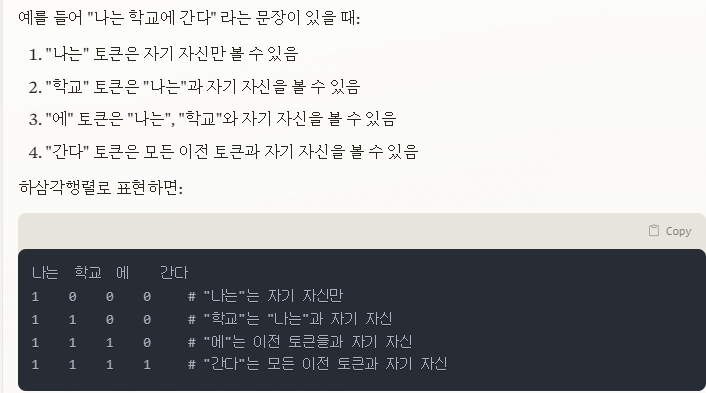


### 디코더 층 및 디코더 구현 

In [64]:
class TransformerDecoderLayer(nn.Module):
  def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
    super().__init__()
    self.self_attn = MultiheadAttention(d_model, d_model, nhead)
    self.multihead_attn = MultiheadAttention(d_model, d_model, nhead)
    self.feed_forward = PreLayerNormFeedForward(d_model, dim_feedforward, dropout)

    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)

  def forward(self, tgt, encoder_output, is_causal=True):
    # 셀프 어텐션 연산
    x = self.norm1(tgt)
    x = x + self.dropout1(self.self_attn(x, x, x, is_causal=is_causal))
    # 크로스 어텐션 연산
    x = self.norm2(x)
    x = x + self.dropout2(self.multihead_attn(x, encoder_output, encoder_output, is_causal=False))
    # 피드 포워드 연산
    x = self.feed_forward(x)
    return x

In [65]:
import copy
def get_clones(module, N):
  return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class TransformerDecoder(nn.Module):
  def __init__(self, decoder_layer, num_layers):
    super().__init__()
    self.layers = get_clones(decoder_layer, num_layers)
    self.num_layers = num_layers

  def forward(self, tgt, src):
    output = tgt
    for mod in self.layers:
        output = mod(tgt, src)
    return output

In [72]:
# 하이퍼파라미터
d_model = 512
n_head = 8
dim_feedforward = 2048
dropout = 0.1
num_layers = 6
batch_size = 32
src_seq_length = 100
tgt_seq_length = 50

# 디코더 생성
decoder_layer = TransformerDecoderLayer(
    d_model=d_model,
    nhead=n_head,
    dim_feedforward=dim_feedforward,
    dropout=dropout
)

transformer_decoder = TransformerDecoder(
    decoder_layer=decoder_layer,
    num_layers=num_layers
)

# 입력 데이터
encoder_output = torch.randn(batch_size, src_seq_length, d_model)
decoder_input = torch.randn(batch_size, tgt_seq_length, d_model)

# 실행
output = transformer_decoder(decoder_input, encoder_output)

# 결과 출력
print(f"Encoder output shape: {encoder_output.shape}")
print(f"Decoder input shape: {decoder_input.shape}")
print(f"Decoder output shape: {output.shape}")

Encoder output shape: torch.Size([32, 100, 512])
Decoder input shape: torch.Size([32, 50, 512])
Decoder output shape: torch.Size([32, 50, 512])
